In [1]:
import tensorflow as tf
print("Tensorflow Version :"+str(tf.__version__))
import os
import datetime
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print("--All Packages Imported--")
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

E:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow Version :1.12.0
--All Packages Imported--
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
#We are defining our discriminator here which will be a convolutional neural network. The generator is the opposite of the 
#discriminator and will be a decconvolutional network
def discriminator(x_image,reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()
    #------------------1ST BLOCK----------------------------
    #Our First Block will have a CONV2D-->RELU-->POOL
    #We will define the wights first which will come from the normal distribution
    #Next we will define the bias which will also come from the normal distribution again
    #The filter size will be of 5*5*1 and there will be 32 filters at starting
    #Next the pooling will be average pooling and the padding will be same so that the dimesnion is retained 
    d_w1=tf.get_variable(name="d_w1",shape=[5,5,1,32],initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1=tf.get_variable(name="d_b1",shape=[32],initializer=tf.constant_initializer(0))
    d1=tf.nn.conv2d(input=x_image,filter=d_w1,strides=[1,1,1,1],padding="SAME")
    d1=d1+d_b1
    #Applying the relu activation function to our output
    d1=tf.nn.relu(d1)
    #Now our average pooling
    d1=tf.nn.avg_pool(d1,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    #--------------------1ST BLOCK ENDS------------------------
    #--------------------2ND BLOCK BEGINS------------------------
    #As with all the convolutional neural network this block will be repeated
    #Our Second Block will have a CONV2D-->RELU-->POOL
    #We will define the wights first which will come from the normal distribution
    #Next we will define the bias which will also come from the normal distribution again
    #The filter size will be of 5*5*1 and there will be 32 filters at starting
    #Next the pooling will be average pooling and the padding will be same so that the dimesnion is retained 
    d_w2=tf.get_variable(name="d_2",shape=[5,5,32,64],initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2=tf.get_variable(name="d_b2",shape=[64],initializer=tf.constant_initializer(0))
    d2=tf.nn.conv2d(input=d1,filter=d_w2,strides=[1,1,1,1],padding="SAME")
    d2=d2+d_b2
    #Applying the relu activation function to our output
    d2=tf.nn.relu(d2)
    #Now our average pooling
    d2=tf.nn.avg_pool(d2,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    #--------------------2ND BLOCK ENDS--------------------------
    #The fourth and the fifth block will follow a fully connected layers 
    #--------------------3RD BLOCK BEGINS------------------------
    #We will define the wights first which will come from the normal distribution
    #Next we will define the bias which will also come from the normal distribution again
    d_w3=tf.get_variable(name="d_w3",shape=[7*7*64,1024],initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3=tf.get_variable(name="d_b3",shape=[1024],initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3=tf.matmul(d3,d_w3)
    d3=d3+d_b3
    #Applying the relu activation function to our output
    d3=tf.nn.relu(d3)
    #--------------------3RD BLOCK ENDS--------------------------
    #--------------------4TH BLOCK BEGINS----------------------
    d_w4=tf.get_variable(name="d_w4",shape=[1024,1],initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4=tf.get_variable(name="d_b4",shape=[1],initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3,d_w4) + d_b4
    #--------------------4TH BLOCK ENDS------------------------
    return d4

In [3]:
#we can think the generator as  kind of opposite of discriminator and opp. of conV2D... It is deconvolutional neural network
#it takes a d-dimensional noise vector and upsample it to become a 28*28 image.
#Itb takes random inputs and eventually maps it to a 1*28*28*1 image to match the MNIST shape
#We begin by generating a dense 14×14 set of values, and then run through a handful of filters of
#varying sizes and numbers of channels
#weight matrices get progressively smaller
def generator(batch_size,z_dim):
    z=tf.truncated_normal([batch_size,z_dim],mean=0,stddev=1,name='z')
    #first deconv block
    g_w1=tf.get_variable('g_w1',[z_dim,3136],dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1=tf.get_variable('g_b1',[3136],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1=tf.matmul(z,g_w1)+g_b1
    g1=tf.reshape(g1,[-1,56,56,1])
    g1=tf.contrib.layers.batch_norm(g1,epsilon=1e-5,scope='bn1')
    g1=tf.nn.relu(g1)

    # Generate 50 features
    g_w2=tf.get_variable('g_w2',[3, 3, 1, z_dim/2],dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2=tf.get_variable('g_b2',[z_dim/2],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2=tf.nn.conv2d(g1,g_w2,strides=[1, 2, 2, 1],padding='SAME')
    g2=g2+g_b2
    g2=tf.contrib.layers.batch_norm(g2,epsilon=1e-5,scope='bn2')
    g2=tf.nn.relu(g2)
    g2=tf.image.resize_images(g2,[56,56])

    # Generate 25 features
    g_w3=tf.get_variable('g_w3',[3,3,z_dim/2,z_dim/4],dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3=tf.get_variable('g_b3',[z_dim/4],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3=tf.nn.conv2d(g2,g_w3,strides=[1,2,2,1],padding='SAME')
    g3=g3+g_b3
    g3=tf.contrib.layers.batch_norm(g3,epsilon=1e-5,scope='bn3')
    g3=tf.nn.relu(g3)
    g3=tf.image.resize_images(g3,[56, 56])

    # Final convolution with one output channel
    g_w4=tf.get_variable('g_w4',[1,1,z_dim/4,1],dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4=tf.get_variable('g_b4',[1],initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4=tf.nn.conv2d(g3,g_w4,strides=[1,2,2,1],padding='SAME')
    g4=g4+g_b4
    g4=tf.sigmoid(g4)

    # No batch normalization at the final layer, but we do add
    # a sigmoid activator to make the generated images crisper.
    # Dimensions of g4: batch_size x 28 x 28 x 1

    return g4

In [4]:
sess = tf.Session() 
batch_size = 50 
z_dimensions = 100 
x_placeholder = tf.placeholder("float", shape = [None,28,28,1], name='x_placeholder') 
Gz = generator(batch_size, z_dimensions) 
Dx = discriminator(x_placeholder) 
with tf.variable_scope(tf.get_variable_scope()) as scope:
    pass 
Dg = discriminator(Gz, reuse=True)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg))) 
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.fill([batch_size, 1], 0.9))) 
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg))) 
d_loss = d_loss_real + d_loss_fake 
tvars = tf.trainable_variables() 
d_vars = [var for var in tvars if  'd_' in var.name] 
g_vars = [var for var in tvars if not 'g_' in var.name] 

with tf.variable_scope(scope):    
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars) 
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars) 
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)


In [5]:
#Outputs a Summary protocol buffer containing a single scalar value.
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

d_real_count_ph = tf.placeholder(tf.float32)
d_fake_count_ph = tf.placeholder(tf.float32)
g_count_ph = tf.placeholder(tf.float32)

tf.summary.scalar('d_real_count', d_real_count_ph)
tf.summary.scalar('d_fake_count', d_fake_count_ph)
tf.summary.scalar('g_count', g_count_ph)

# Sanity check to see how the discriminator evaluates
# generated and real MNIST images
d_on_generated = tf.reduce_mean(discriminator(generator(batch_size, z_dimensions)))
d_on_real = tf.reduce_mean(discriminator(x_placeholder))

tf.summary.scalar('d_on_generated_eval', d_on_generated)
tf.summary.scalar('d_on_real_eval', d_on_real)

images_for_tensorboard = generator(batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 10)
merged = tf.summary.merge_all()
logdir = "tensorboard/gan/"
writer = tf.summary.FileWriter(logdir, sess.graph)
print(logdir)

tensorboard/gan/


TRAINING STEP 0 AT 2019-01-12 00:32:36.848645
Discriminator classification [0.00458989]


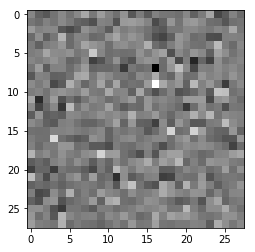

Discriminator classification [0.0046239]


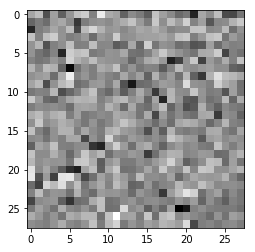

Discriminator classification [0.00460773]


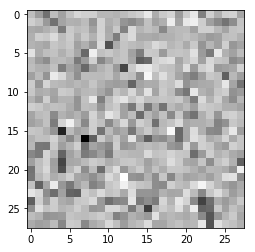

saved to models/pretrained_gan.ckpt-0
TRAINING STEP 1000 AT 2019-01-12 00:35:59.744568
Discriminator classification [0.3984331]


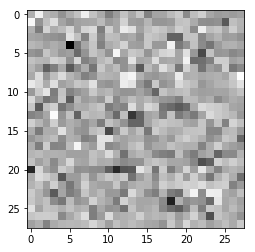

Discriminator classification [0.39866328]


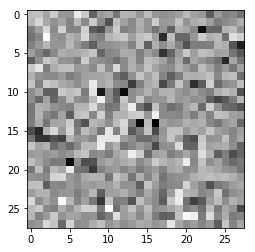

Discriminator classification [0.39799282]


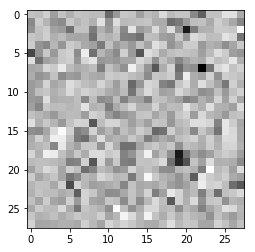

TRAINING STEP 2000 AT 2019-01-12 00:39:33.868778
Discriminator classification [0.38158712]


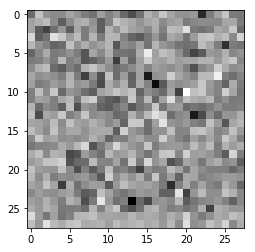

Discriminator classification [0.38078046]


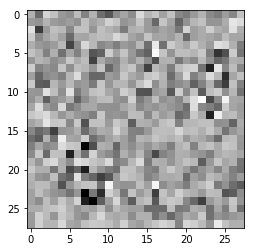

Discriminator classification [0.38039568]


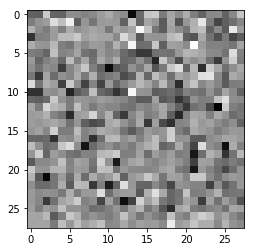

TRAINING STEP 3000 AT 2019-01-12 00:43:09.757199
Discriminator classification [0.38198322]


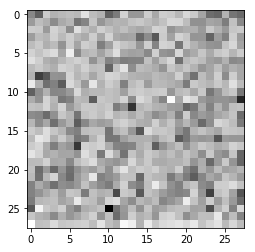

Discriminator classification [0.38207033]


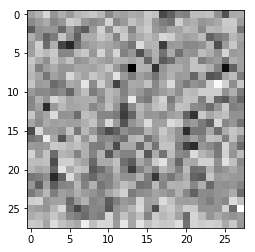

Discriminator classification [0.38063332]


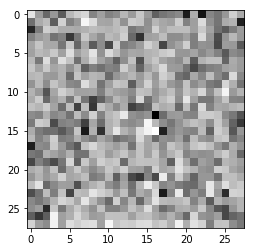

TRAINING STEP 4000 AT 2019-01-12 00:46:45.610375
Discriminator classification [0.3865311]


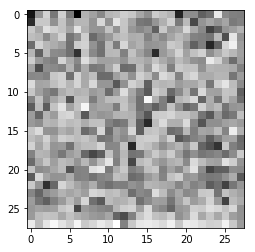

Discriminator classification [0.38434643]


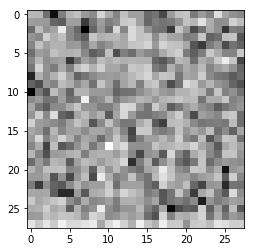

Discriminator classification [0.38351682]


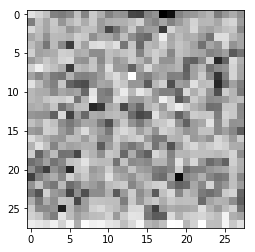

TRAINING STEP 5000 AT 2019-01-12 00:50:21.507882
Discriminator classification [0.38923246]


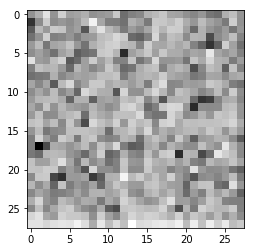

Discriminator classification [0.3863619]


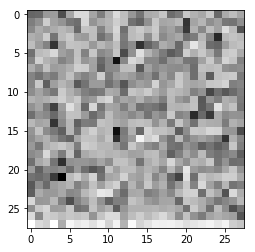

Discriminator classification [0.39196676]


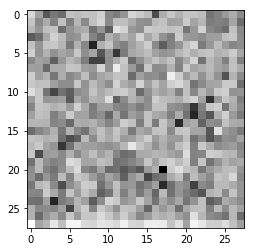

saved to models/pretrained_gan.ckpt-5000
TRAINING STEP 6000 AT 2019-01-12 00:53:59.234419
Discriminator classification [0.3887769]


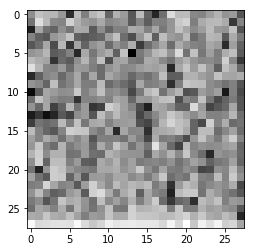

Discriminator classification [0.39216733]


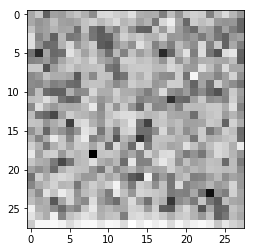

Discriminator classification [0.3937119]


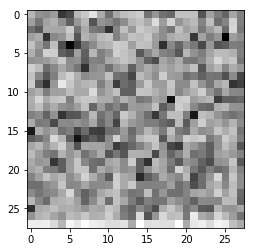

TRAINING STEP 7000 AT 2019-01-12 00:57:34.237187
Discriminator classification [0.39151308]


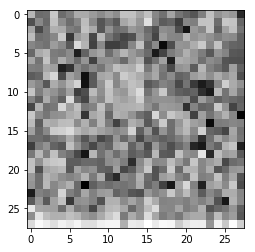

Discriminator classification [0.3915264]


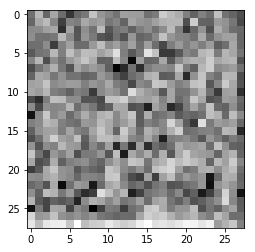

Discriminator classification [0.39039022]


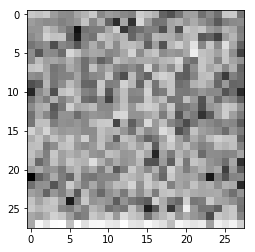

TRAINING STEP 8000 AT 2019-01-12 01:01:11.448636
Discriminator classification [0.39501286]


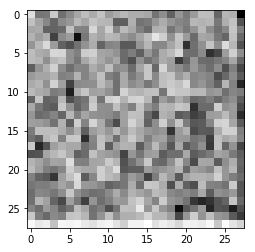

Discriminator classification [0.39513916]


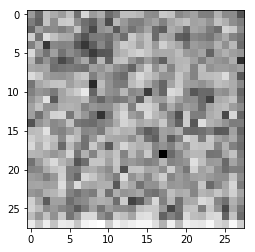

Discriminator classification [0.39012378]


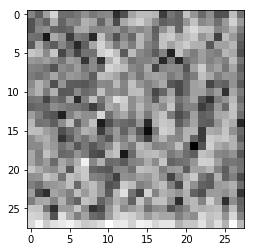

TRAINING STEP 9000 AT 2019-01-12 01:04:49.474088
Discriminator classification [0.3936479]


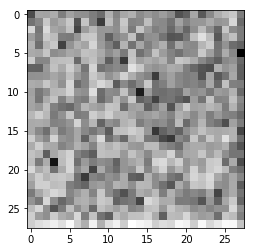

Discriminator classification [0.3912782]


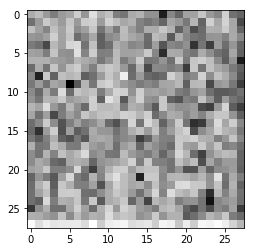

Discriminator classification [0.39390028]


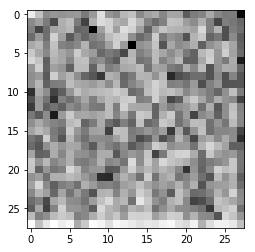

TRAINING STEP 10000 AT 2019-01-12 01:08:24.643729
Discriminator classification [0.3857922]


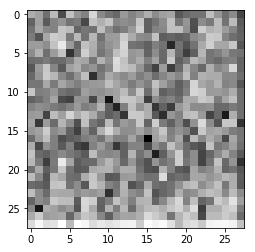

Discriminator classification [0.3849637]


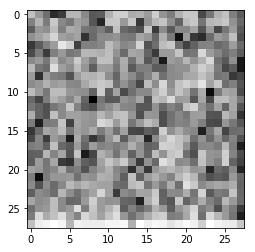

Discriminator classification [0.3794749]


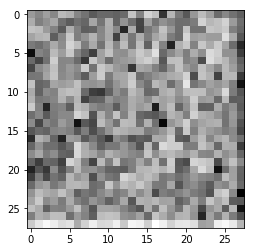

saved to models/pretrained_gan.ckpt-10000
TRAINING STEP 11000 AT 2019-01-12 01:12:01.782490
Discriminator classification [0.37262225]


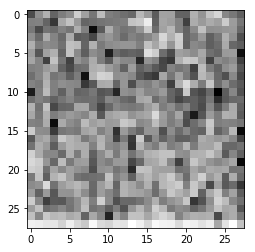

Discriminator classification [0.3766301]


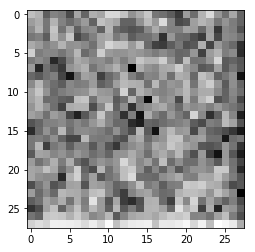

Discriminator classification [0.3767311]


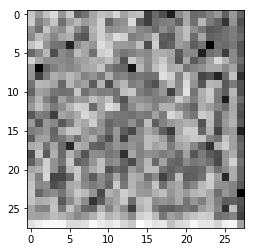

TRAINING STEP 12000 AT 2019-01-12 01:15:38.260169
Discriminator classification [0.38100868]


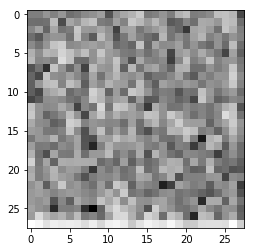

Discriminator classification [0.3772345]


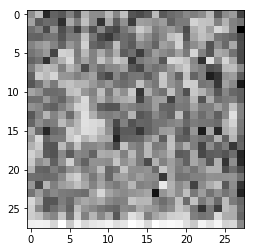

Discriminator classification [0.37543142]


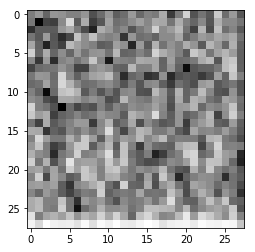

TRAINING STEP 13000 AT 2019-01-12 01:19:17.488564
Discriminator classification [0.38105622]


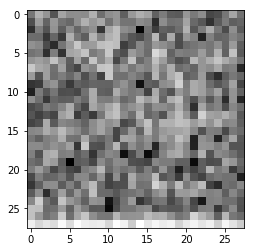

Discriminator classification [0.3784122]


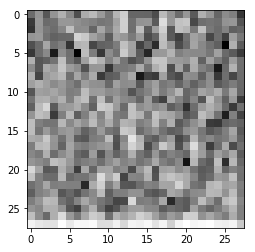

Discriminator classification [0.38306877]


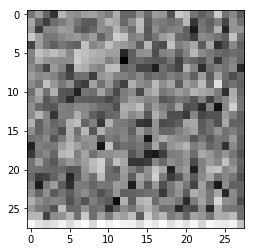

TRAINING STEP 14000 AT 2019-01-12 01:22:52.850203
Discriminator classification [0.38097316]


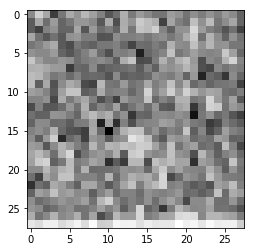

Discriminator classification [0.37698278]


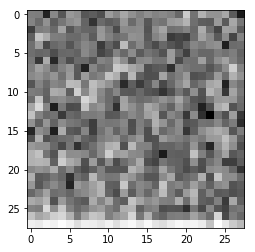

Discriminator classification [0.3791989]


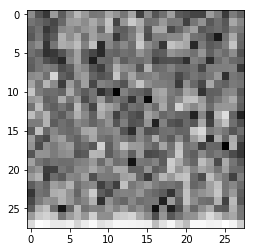

TRAINING STEP 15000 AT 2019-01-12 01:26:28.784740
Discriminator classification [0.37374645]


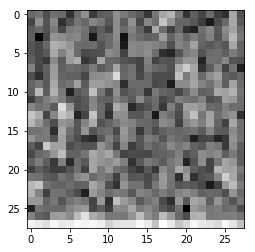

Discriminator classification [0.38424805]


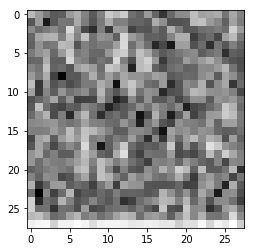

Discriminator classification [0.374108]


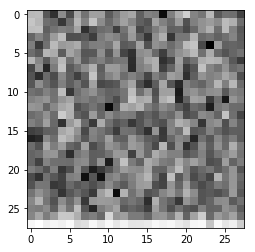

saved to models/pretrained_gan.ckpt-15000
TRAINING STEP 16000 AT 2019-01-12 01:30:05.537652
Discriminator classification [0.37721258]


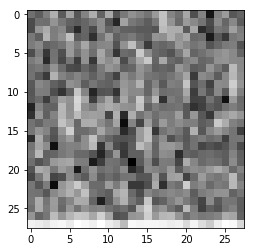

Discriminator classification [0.37796637]


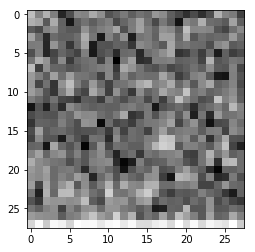

Discriminator classification [0.37299022]


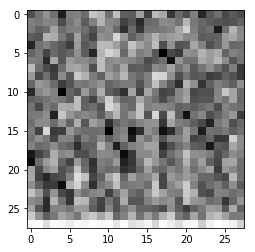

TRAINING STEP 17000 AT 2019-01-12 01:33:40.337456
Discriminator classification [0.3790377]


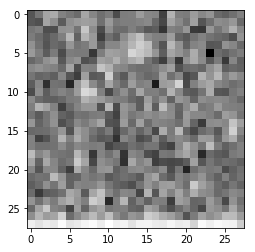

Discriminator classification [0.37987265]


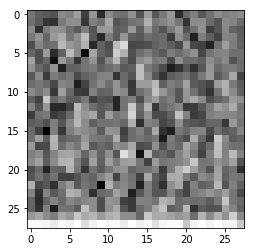

Discriminator classification [0.37974167]


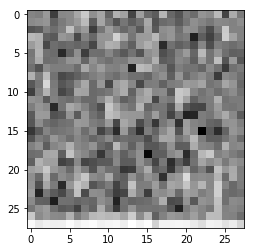

TRAINING STEP 18000 AT 2019-01-12 01:37:15.219704
Discriminator classification [0.3742645]


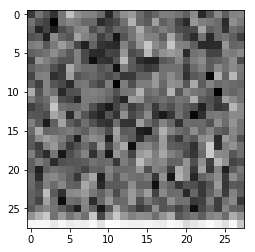

Discriminator classification [0.38358322]


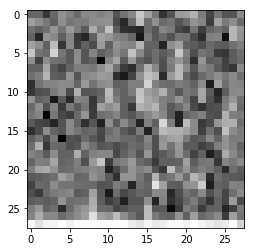

Discriminator classification [0.3799385]


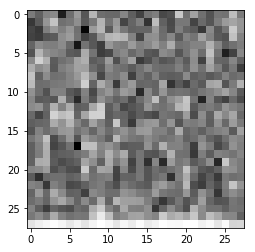

TRAINING STEP 19000 AT 2019-01-12 01:40:49.987295
Discriminator classification [0.37884918]


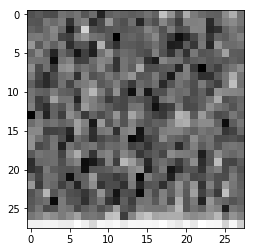

Discriminator classification [0.37691858]


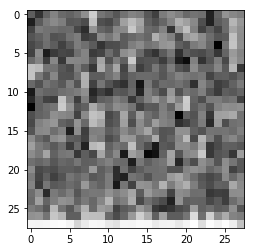

Discriminator classification [0.3801846]


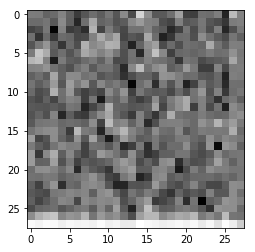

TRAINING STEP 20000 AT 2019-01-12 01:44:26.049104
Discriminator classification [0.37817588]


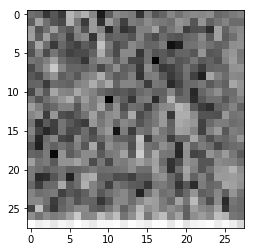

Discriminator classification [0.3736288]


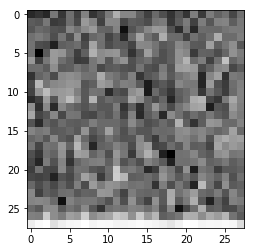

Discriminator classification [0.38019043]


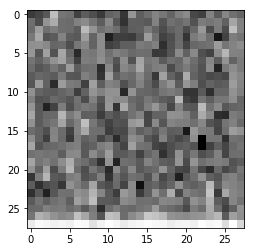

saved to models/pretrained_gan.ckpt-20000
TRAINING STEP 21000 AT 2019-01-12 01:48:02.772365
Discriminator classification [0.37233794]


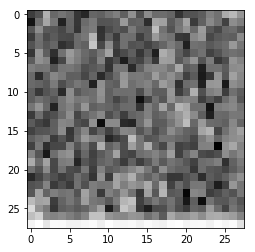

Discriminator classification [0.37663198]


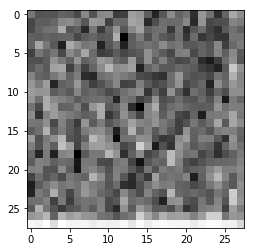

Discriminator classification [0.37723684]


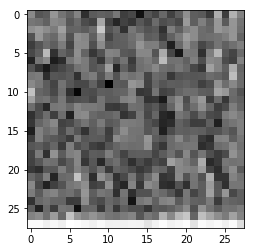

TRAINING STEP 22000 AT 2019-01-12 01:51:37.657141
Discriminator classification [0.3751098]


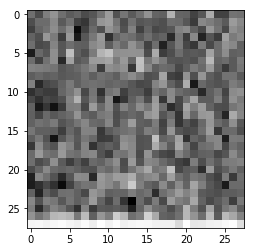

Discriminator classification [0.37435094]


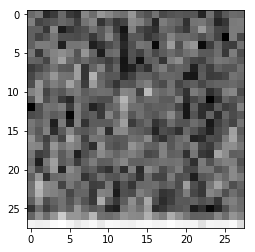

Discriminator classification [0.3752366]


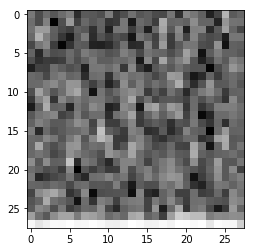

TRAINING STEP 23000 AT 2019-01-12 01:55:12.410360
Discriminator classification [0.37507305]


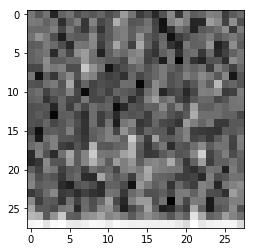

Discriminator classification [0.37496167]


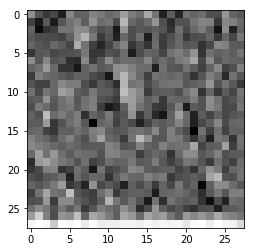

Discriminator classification [0.37651962]


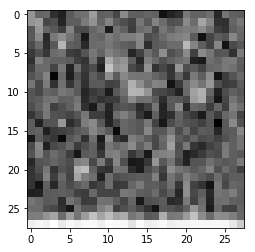

TRAINING STEP 24000 AT 2019-01-12 01:58:47.228951
Discriminator classification [0.37820923]


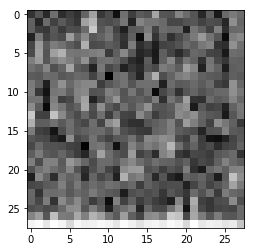

Discriminator classification [0.37600404]


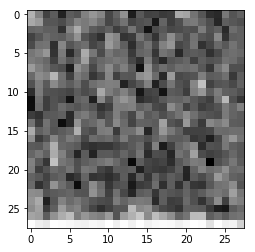

Discriminator classification [0.37721506]


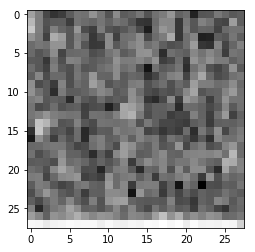

TRAINING STEP 25000 AT 2019-01-12 02:02:21.918722
Discriminator classification [0.37305766]


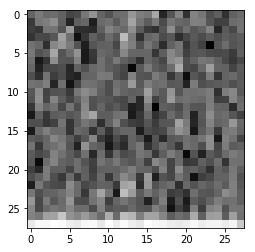

Discriminator classification [0.37752223]


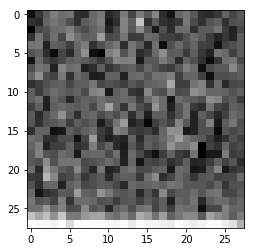

Discriminator classification [0.37307733]


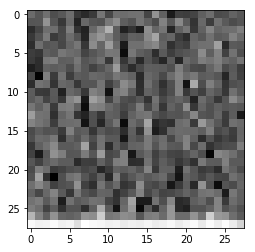

saved to models/pretrained_gan.ckpt-25000
TRAINING STEP 26000 AT 2019-01-12 02:05:58.414638
Discriminator classification [0.37474597]


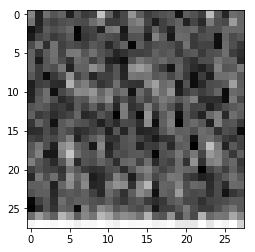

Discriminator classification [0.3740766]


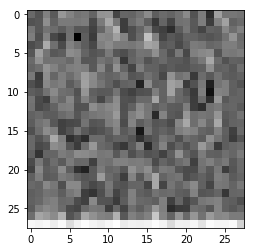

Discriminator classification [0.38235858]


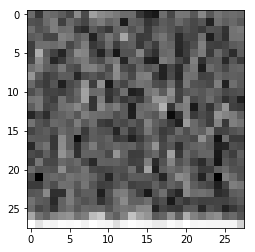

TRAINING STEP 27000 AT 2019-01-12 02:09:33.222945
Discriminator classification [0.37079722]


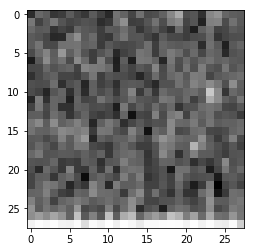

Discriminator classification [0.37485155]


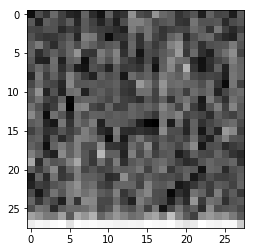

Discriminator classification [0.3723891]


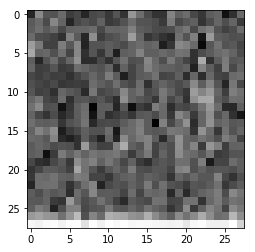

TRAINING STEP 28000 AT 2019-01-12 02:13:08.111362
Discriminator classification [0.36976278]


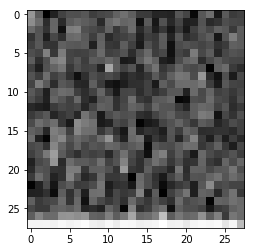

Discriminator classification [0.36730802]


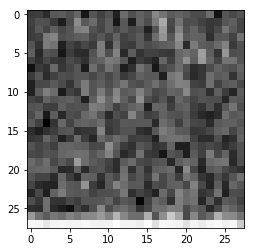

Discriminator classification [0.3689671]


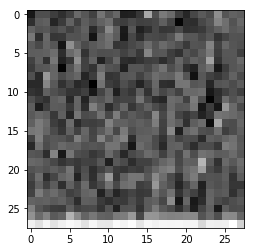

TRAINING STEP 29000 AT 2019-01-12 02:16:43.290939
Discriminator classification [0.36837253]


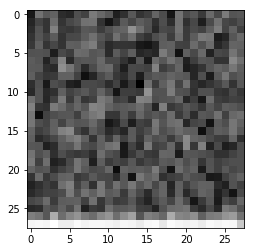

Discriminator classification [0.36638597]


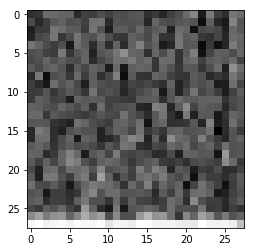

Discriminator classification [0.36690772]


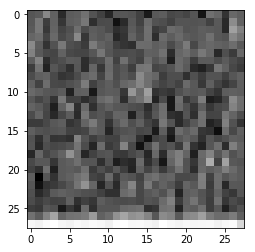

TRAINING STEP 30000 AT 2019-01-12 02:20:18.867464
Discriminator classification [0.3439113]


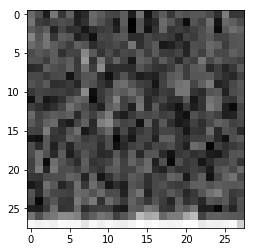

Discriminator classification [0.34469816]


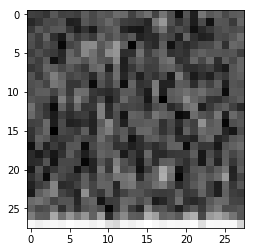

Discriminator classification [0.34166726]


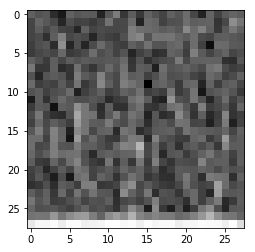

saved to models/pretrained_gan.ckpt-30000
TRAINING STEP 31000 AT 2019-01-12 02:23:56.133075
Discriminator classification [0.3568574]


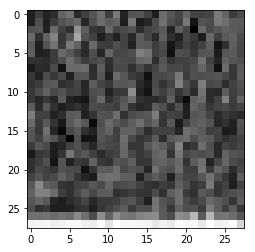

Discriminator classification [0.35939214]


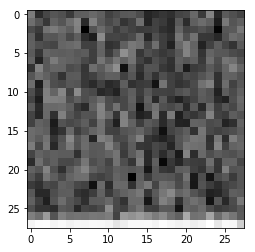

Discriminator classification [0.35747978]


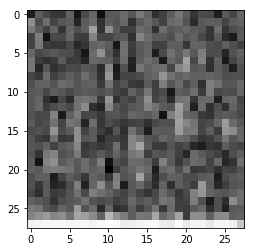

TRAINING STEP 32000 AT 2019-01-12 02:27:31.175281
Discriminator classification [0.3550623]


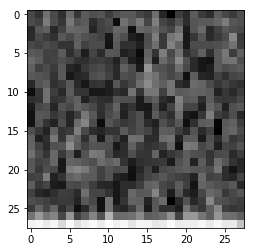

Discriminator classification [0.35611764]


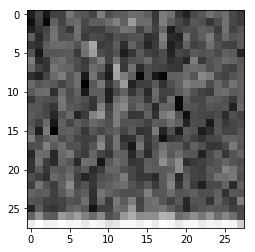

Discriminator classification [0.35858378]


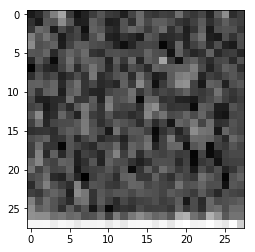

TRAINING STEP 33000 AT 2019-01-12 02:31:06.285503
Discriminator classification [0.35763282]


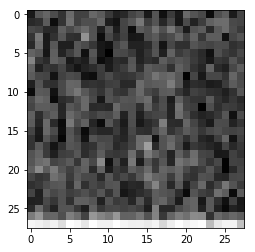

Discriminator classification [0.35491604]


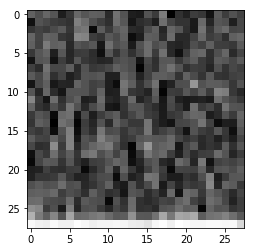

Discriminator classification [0.3547444]


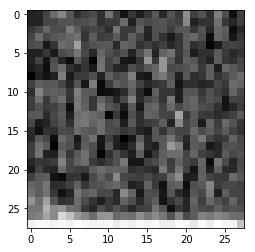

TRAINING STEP 34000 AT 2019-01-12 02:34:41.052390
Discriminator classification [0.35215738]


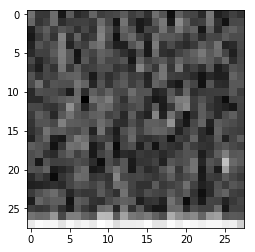

Discriminator classification [0.355022]


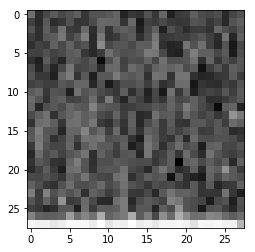

Discriminator classification [0.3510481]


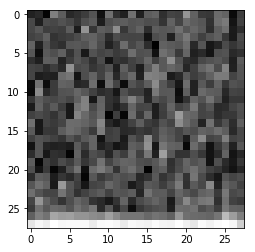

TRAINING STEP 35000 AT 2019-01-12 02:38:16.105138
Discriminator classification [0.3500358]


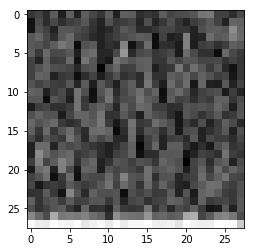

Discriminator classification [0.35254353]


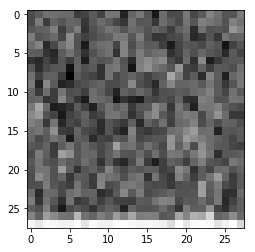

Discriminator classification [0.3525276]


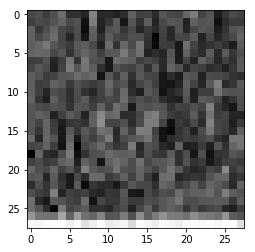

saved to models/pretrained_gan.ckpt-35000
TRAINING STEP 36000 AT 2019-01-12 02:41:53.257913
Discriminator classification [0.35169393]


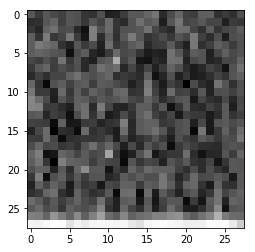

Discriminator classification [0.3496976]


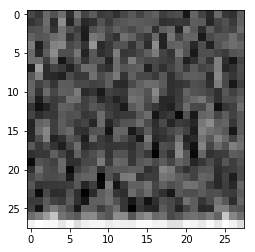

Discriminator classification [0.35187268]


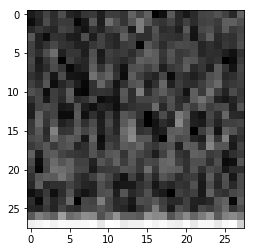

TRAINING STEP 37000 AT 2019-01-12 02:45:28.237568
Discriminator classification [0.3494927]


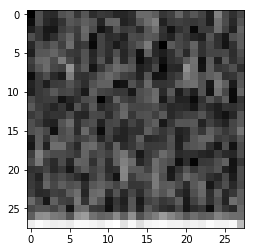

Discriminator classification [0.34874725]


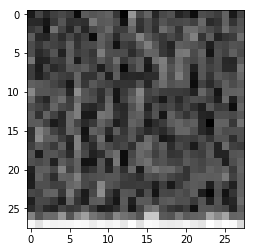

Discriminator classification [0.35115588]


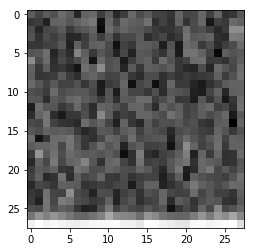

TRAINING STEP 38000 AT 2019-01-12 02:49:03.277734
Discriminator classification [0.3483431]


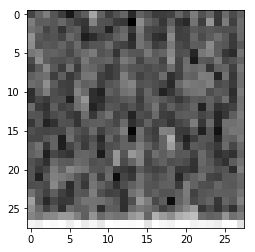

Discriminator classification [0.35019392]


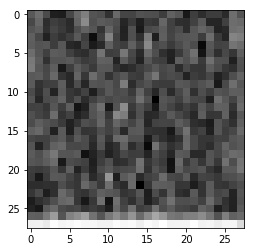

Discriminator classification [0.35238063]


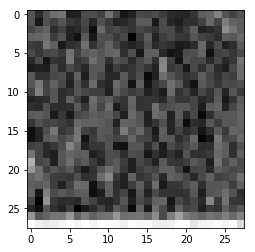

TRAINING STEP 39000 AT 2019-01-12 02:52:38.650019
Discriminator classification [0.35084376]


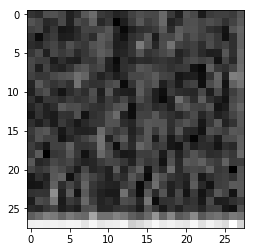

Discriminator classification [0.34816316]


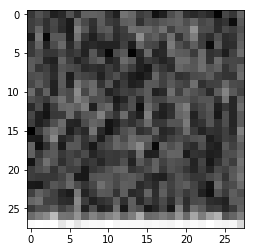

Discriminator classification [0.3481662]


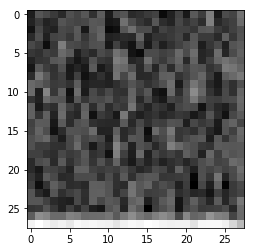

TRAINING STEP 40000 AT 2019-01-12 02:56:13.579620
Discriminator classification [0.351658]


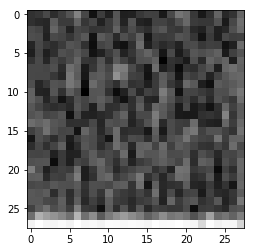

Discriminator classification [0.34862676]


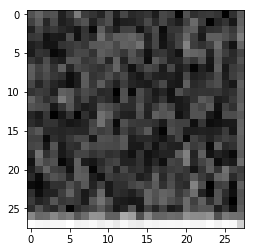

Discriminator classification [0.35156882]


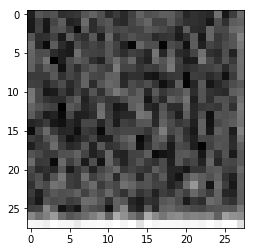

saved to models/pretrained_gan.ckpt-40000
TRAINING STEP 41000 AT 2019-01-12 02:59:51.139307
Discriminator classification [0.35263842]


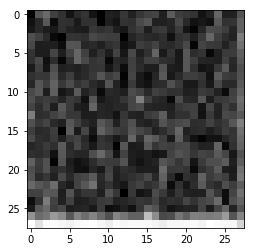

Discriminator classification [0.35157076]


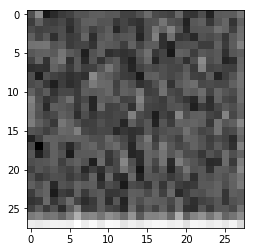

Discriminator classification [0.3501848]


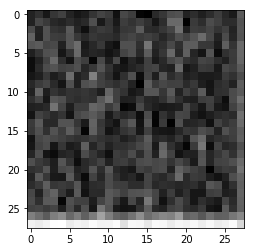

TRAINING STEP 42000 AT 2019-01-12 03:03:26.060515
Discriminator classification [0.34949633]


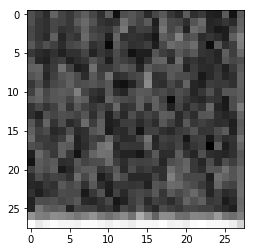

Discriminator classification [0.34761244]


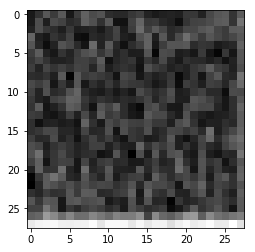

Discriminator classification [0.3493406]


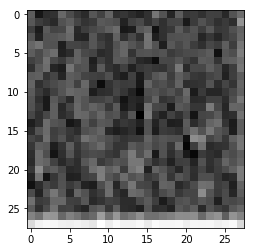

TRAINING STEP 43000 AT 2019-01-12 03:07:01.195941
Discriminator classification [0.3499696]


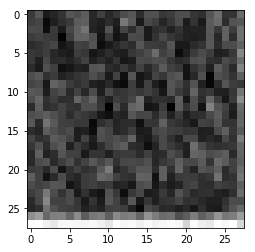

Discriminator classification [0.35022235]


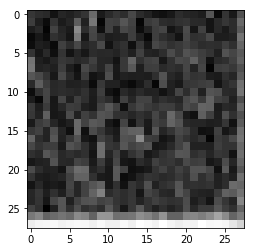

Discriminator classification [0.34860957]


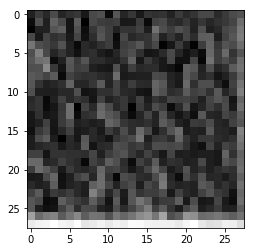

TRAINING STEP 44000 AT 2019-01-12 03:10:36.243457
Discriminator classification [0.34917825]


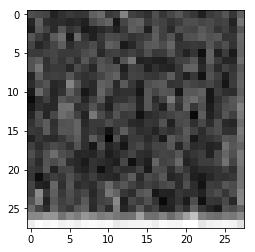

Discriminator classification [0.3507434]


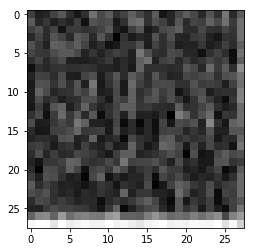

Discriminator classification [0.35100624]


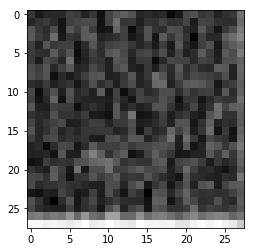

TRAINING STEP 45000 AT 2019-01-12 03:14:11.294244
Discriminator classification [0.34986952]


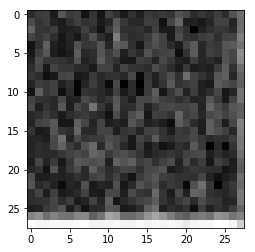

Discriminator classification [0.35056388]


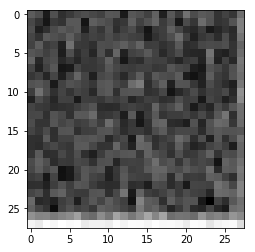

Discriminator classification [0.35167578]


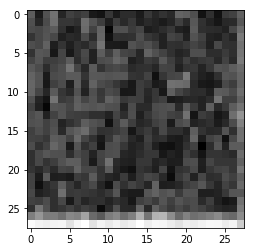

saved to models/pretrained_gan.ckpt-45000
TRAINING STEP 46000 AT 2019-01-12 03:17:48.337492
Discriminator classification [0.34506458]


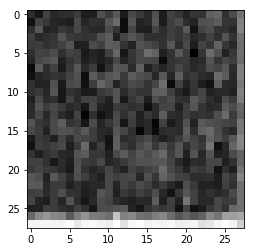

Discriminator classification [0.3508991]


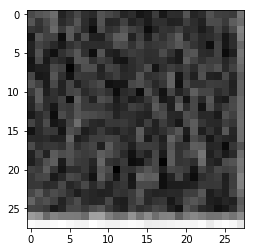

Discriminator classification [0.34851587]


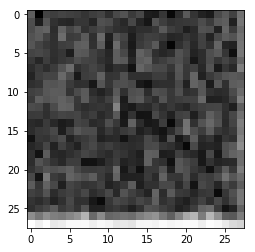

TRAINING STEP 47000 AT 2019-01-12 03:21:23.391829
Discriminator classification [0.34662127]


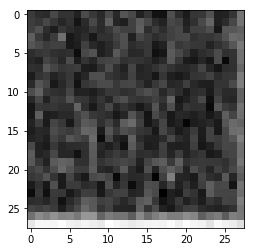

Discriminator classification [0.34742957]


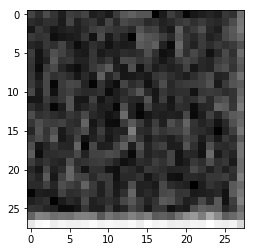

Discriminator classification [0.35008594]


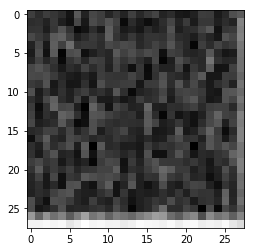

TRAINING STEP 48000 AT 2019-01-12 03:24:58.617158
Discriminator classification [0.3489706]


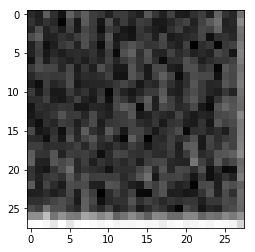

Discriminator classification [0.34720737]


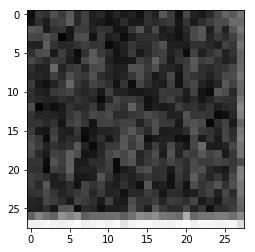

Discriminator classification [0.34863907]


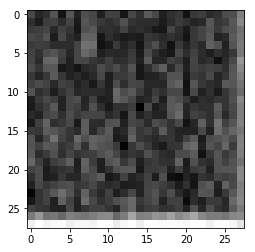

TRAINING STEP 49000 AT 2019-01-12 03:28:33.904663
Discriminator classification [0.34645444]


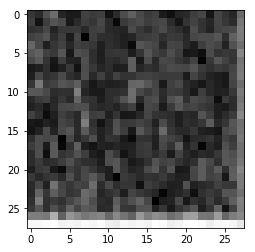

Discriminator classification [0.3499604]


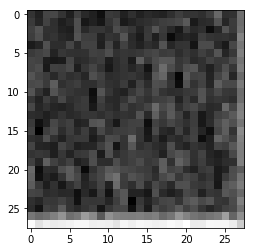

Discriminator classification [0.34758928]


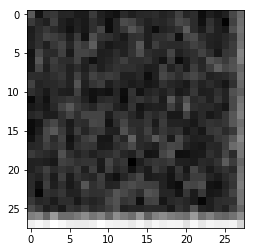

In [6]:
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

#During every iteration, there will be two updates being made, one to the discriminator and one to the generator. 
#For the generator update, we’ll feed in a random z vector to the generator and pass that output to the discriminator
#to obtain a probability score (this is the Dg variable we specified earlier).
#As we remember from our loss function, the cross entropy loss gets minimized, 
#and only the generator’s weights and biases get updated.
#We'll do the same for the discriminator update. We’ll be taking a batch of images 
#from the mnist variable we created way at the beginning of our program.
#These will serve as the positive examples, while the images in the previous section are the negative ones.

gLoss = 0
dLossFake, dLossReal = 1, 1
d_real_count, d_fake_count, g_count = 0, 0, 0
for i in range(50000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    if dLossFake > 0.6:
        # Train discriminator on generated images
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_fake, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_fake_count += 1

    if gLoss > 0.5:
        # Train the generator
        _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        g_count += 1

    if dLossReal > 0.45:
        # If the discriminator classifies real images as fake,
        # train discriminator on real values
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_real, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_real_count += 1

    if i % 10 == 0:
        real_image_batch = mnist.validation.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        summary = sess.run(merged, {x_placeholder: real_image_batch, d_real_count_ph: d_real_count,
                                    d_fake_count_ph: d_fake_count, g_count_ph: g_count})
        writer.add_summary(summary, i)
        d_real_count, d_fake_count, g_count = 0, 0, 0

    if i % 1000 == 0:
        # Periodically display a sample image in the notebook
        # (These are also being sent to TensorBoard every 10 iterations)
        images = sess.run(generator(3, z_dimensions))
        d_result = sess.run(discriminator(x_placeholder), {x_placeholder: images})
        print("TRAINING STEP", i, "AT", datetime.datetime.now())
        for j in range(3):
            print("Discriminator classification", d_result[j])
            im = images[j, :, :, 0]
            plt.imshow(im.reshape([28, 28]), cmap='Greys')
            plt.show()

    if i % 5000 == 0:
        save_path = saver.save(sess, "models/pretrained_gan.ckpt", global_step=i)
        print("saved to %s" % save_path)

[0.34643632]


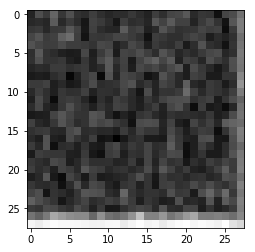

[0.3478757]


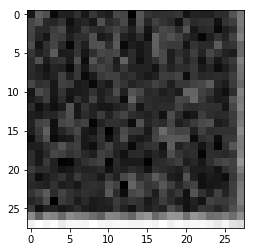

[0.34507596]


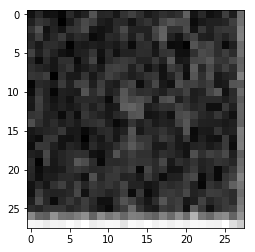

[0.34830305]


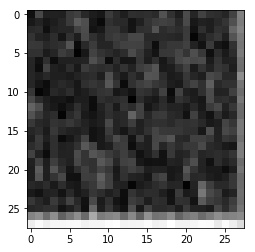

[0.35067752]


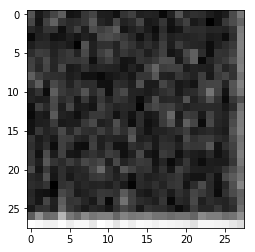

[0.34699976]


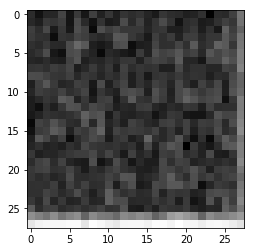

[0.34491602]


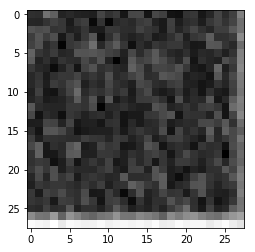

[0.34603426]


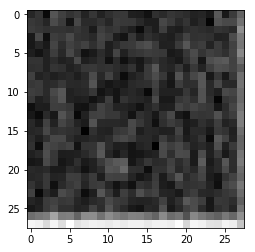

[0.34766355]


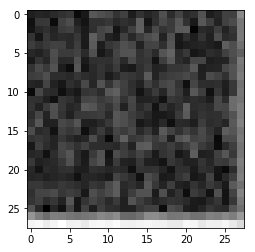

[0.34768716]


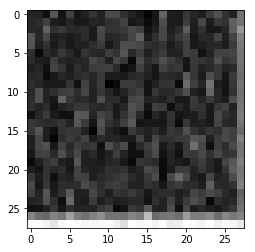

[0.72461146]


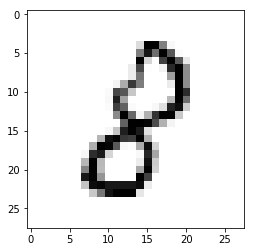

[1.9265367]


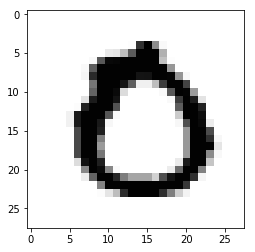

[1.5906171]


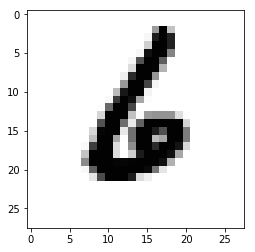

[1.3357347]


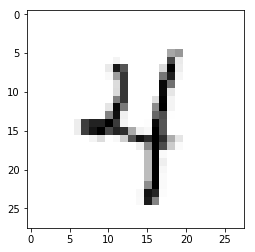

[1.2036557]


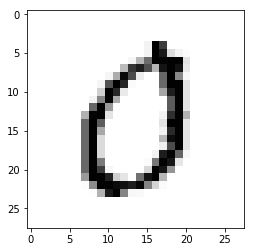

[1.2621654]


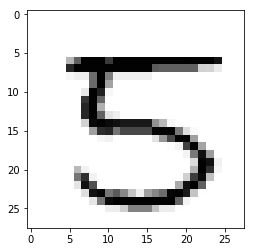

[1.5406954]


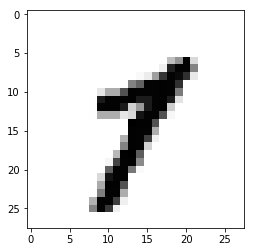

[1.2358917]


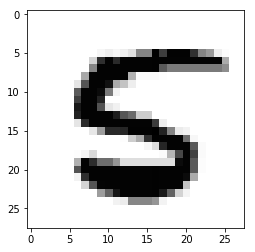

[1.0365847]


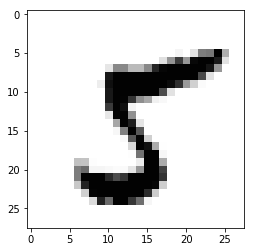

[1.4138892]


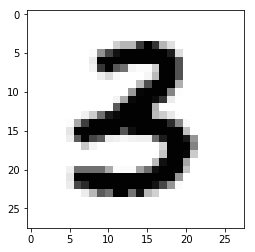

In [7]:
test_images = sess.run(generator(10, 100))
test_eval = sess.run(discriminator(x_placeholder), {x_placeholder: test_images})

real_images = mnist.validation.next_batch(10)[0].reshape([10, 28, 28, 1])
real_eval = sess.run(discriminator(x_placeholder), {x_placeholder: real_images})

# Show discriminator's probabilities for the generated images,
# and display the images
for i in range(10):
    print(test_eval[i])
    plt.imshow(test_images[i, :, :, 0], cmap='Greys')
    plt.show()

# Now do the same for real MNIST images
for i in range(10):
    print(real_eval[i])
    plt.imshow(real_images[i, :, :, 0], cmap='Greys')
    plt.show()